In [18]:
import numpy as np
from linear import LinintGrow, LinintEqui
from DiscretizeTools import grow_grid, rouwenhorst
from scipy.optimize import root
import matplotlib.pyplot as plt


In [2]:
T = 40
J = 12
JR = 10
NP = 2
NS = 5
NA = 100

γ = 0.5
egam = 1 - 1/γ
ν = 0.335
β = 0.998**5

σθ = 0.23
σϵ = 0.05**0.5
ρ = 0.98

α = 0.36
δ = 1 - (1 - 0.0823)**5
Ω = 1.60

al = 0
au = 35
agrow = 0.05

n_p = (1 + 0.01)**5 -1
itermax = 50

damp = 0.3
sig = 1e-4



In [3]:
r = np.zeros(T+1)
rn = np.zeros(T+1)
w = np.zeros(T+1)
wn = np.zeros(T+1)
pp = np.zeros(T+1)

In [4]:
pop = np.zeros((J, T+1))
m = np.zeros((J, T+1))
aplus = np.zeros((J, NA + 1, NP, NS, T + 1))
c = np.zeros((J, NA + 1, NP, NS, T + 1))
l = np.zeros((J, NA + 1, NP, NS, T + 1))
VV = np.zeros((J, NA + 1, NP, NS, T + 1))
v = np.zeros((J, NA + 1, NP, NS, T + 1))
RHS = np.zeros((J, NA + 1, NP, NS, T + 1))
EV = np.zeros((J, NA + 1, NP, NS, T + 1))
Φ = np.zeros((J, NA + 1, NP, NS, T + 1))


c_coh = np.zeros((J,T+1))
l_coh = np.zeros((J,T+1))
y_coh = np.zeros((J,T+1))
a_coh = np.zeros((J,T+1))
v_coh = np.zeros((J,T+1))
VV_coh = np.zeros((J,T+1))
FLC = np.zeros((J,T+1))
m = np.zeros((J,T+1))
PP = np.zeros(T+1)

taxrev = np.zeros((4,T+1))

eff = np.zeros(J)

distθ = [0.5,0.5]

θ = np.exp(np.array([-σθ**0.5,σθ**0.5]))

η, π = rouwenhorst(ρ, σϵ, NS)
η = np.exp(η)


for j in range(J):
    pop[j, 0] = 1/(1+n_p)**j
    
for j in range(J):
    m[j, 0] = pop[j,0]/pop[0,0]

a = grow_grid(al, au, agrow, NA+1)


for j in range(J):
    for p in range(NP):
        for s in range(NS):
            aplus[j, :, p, s, 0] = np.maximum(a/2, np.ones(NA+1)*a[1]/2)


eff[0] = 1.0000
eff[1] = 1.3527
eff[2] = 1.6952
eff[3] = 1.8279
eff[4] = 1.9606
eff[5] = 1.9692
eff[6] = 1.9692
eff[7] = 1.9392
eff[8] = 1.9007
eff[JR-1:] = 0 

tax = np.ones(T+1)*2
τc = np.ones(T+1)*0.075
τw = np.zeros(T+1)
τr = np.zeros(T+1)
τp = np.ones(T+1)*0.1
κ = np.ones(T+1)*0.5

gy = 0.19
by = 0.6/5

K = np.ones(T+1) 
L = np.ones(T+1)
Y = np.ones(T+1)
C = np.ones(T+1)
H = np.ones(T+1)
A = np.ones(T+1)
BA = np.zeros(T+1)
I = (n_p+δ)*K
INC = np.ones(T+1)
DIFF = np.ones(T+1)

G = np.ones(T+1)*gy*Y[0]
B = np.ones(T+1)*by*Y[0]

pen = np.zeros((J,T+1))
pen[JR-1:,0] = κ[0]
    


In [5]:
# current time is t, calculate at which year the agent with age j turns to be age p
def year(t,j,p):
    year = t + p -j
    
    if t == 0 or year <= 0 : year = 0
        
    if t == T or year >= T : year =  T
    
    return year

In [6]:
def margu(cons,lab,it):
    return ν*(cons**ν*(1-lab)**(1-ν))**(1-1/γ)/(pp[it]*cons)


def interpolate(j,t):
    for i in range(NA+1):
        for p in range(NP):
            for s in range(NS):
                RHS[j,i,p,s,t] = 0
                EV[j,i,p,s,t] = 0
                
                for sp in range(NS):
                    chelp = max(c[j,i,p,sp,t],1e-10)
                    lhelp = max(l[j,i,p,sp,t],1e-10)
                    RHS[j,i,p,s,t] += π[s,sp]*margu(chelp,lhelp,t)
                    EV[j,i,p,s,t]  += π[s,sp]*VV[j,i,p,sp,t]
                RHS[j,i,p,s,t] = ((1+rn[t])*β*RHS[j,i,p,s,t])**(-γ)
                EV[j,i,p,s,t] = ((1-1/γ)*EV[j,i,p,s,t])**(1/(1-1/γ))
    return None
    
    

In [7]:
def government(t):
    tm = year(t,1,0)
    tp = year(t,0,1)
    
    G[t] = gy*Y[0]
    B[t] = by*Y[0]
    pen[JR-1:, t] = κ[t]*INC[tm]
    PP[t] = 0
    
    for j in range(JR-1,J):
        PP[t] += pen[j,t]*m[j,t]
        
    expand = G[t] + (1+r[t])*B[t] - (1+n_p)*B[tp]
    
    if tax[t] == 1:
        τc[t] = (expand - (τw[t]*w[t]*L[t] + τr[t]*r[t]*A[t]))/C[t]
        pp[t] = 1 + τc[t]
    
    elif tax[t] == 2:
        τw[t] = (expand - τc[t]*C[t])/(w[t]*L[t] + r[t]*A[t])
        τr[t] = τw[t]
    elif tax[t] == 3:
        τw[t] = (expand - (τc[t]*C[t] + τr[t]*r[t]*A[t]))/(w[t]*L[t])
    else:
        τr[t] = (expand - (τc[t]*C[t] + τw[t]*w[t]*L[t]))/(r[t]*A[t])
        
    
    taxrev[0,t] = τc[t]*C[t]
    taxrev[1,t] = τw[t]*w[t]*L[t]
    taxrev[2,t] = τr[t]*r[t]*A[t]
    taxrev[3,t] = sum(taxrev[:3,t])
    
    τp[t] = PP[t]/(w[t]*L[t])
    
    return None


In [8]:
def prices(t):    
    r[t] = Ω*α*(K[t]/L[t])**(α-1)-δ
    w[t] = Ω*(1-α)*(K[t]/L[t])**α
    rn[t] = r[t]*(1-τr[t])
    wn[t] = w[t]*(1-τw[t]-τp[t])
    pp[t] = 1+τc[t]
    return None


In [9]:
def valuefunc(ap, cons, lab, j, p, s, t):
    chelp = max(cons,1e-10)
    lhelp = min(max(lab,0),1-1e-10)
    
    tp = year(t,j,j+1)
    
    ial, iar, ϕ = LinintGrow(ap,al,au,agrow,NA+1)
    
    val = 0
    
    if j < J-1:
        val = max(ϕ*EV[j+1, ial, p, s, tp] + (1-ϕ)*EV[j+1, iar, p, s, tp], 1e-10)**(1-1/γ)/(1-1/γ)

    val = (chelp**ν*(1-lhelp)**(1-ν))**(1-1/γ)/(1-1/γ) + β*val
    return val
    
    
    
    

In [10]:
def foc(xin,i, j, p, s, t):
    ap = xin
    tp = year(t,j,j+1)
    vind = v[j, i, p, s, t]
    
    wage = wn[t]*eff[j]*θ[p]*η[s]
    
    available = (1 + rn[t])*a[i] + pen[j,t] + vind
    
    if j < JR-1:
        labcom = min(max(ν + (1-ν)*(ap-available)/wage, 0),1-1e-10)
    else:
        labcom = 0
        
    conscom = max((available + wage*labcom -ap)/pp[t],1e-10) 
    
    ial,iar,φ = LinintGrow(ap, al, au, agrow, NA+1)
    
    tomorrow = max(φ*RHS[j+1,ial,p,s,tp]+(1-φ)*RHS[j+1, iar,p,s,tp],0)
    foc = margu(conscom, labcom, t)**(-γ) - tomorrow
    
    return foc
        
        

In [11]:
def solve_household(j, t):
    it = year(t, j, J-1)
    
    for i in range(NA+1):
        aplus[J-1,i,:,:,it] = 0
        c[J-1,i,:,:,it] = ((1+rn[it])*a[i]+ pen[J-1,it] + v[J-1,i,:,:,it])/pp[it]
        l[J-1,i,:,:,it] = 0
        VV[J-1,i,:,:,it] = valuefunc(0, c[J-1, i, 0, 0, it], l[J-1, i, 0, 0, it], J-1, 0,0, it)
    
    interpolate(J-1, it)

    for ij in range(J-2, j-1, -1):
        
        it = year(t, j, ij)
        
        if ij >= JR-1:
            ipmax = 1
            ismax = 1
        else:
            ipmax = NP
            ismax = NS
            
        for i in range(NA+1):
            if (ij >= JR-1 and i == 0 and κ[t] <= 1e-10):
                aplus[ij,i,:,:,it] = 0
                c[ij,i,:,:,it] = 0
                l[ij,i,:,:,it] = 0
                VV[ij,i,:,:,it] = valuefunc(0,0,0,ij,0,0,it)
                continue
            
            for p in range(ipmax):
                for s in range(ismax):

                    
                    res = root(foc, x0 = aplus[ij,i,p,s,it], args = (i, ij, p, s, it), tol = 1e-8)
                    
                    if res.x[0] < 0:
                        aplus[ij,i,p,s,it] = 0
                        wage = wn[it]*eff[ij]*θ[p]*η[s]
                        vind = v[ij,i,p,s,it]
                        available = (1+rn[it])*a[i] + pen[ij,it] + vind
                        if ij < JR-1:
                            labcom = min(max(ν-(1-ν)*available/wage,0), 1-1e-10)
                        else:
                            labcom = 0
                        conscom = max((available + wage *labcom)/pp[it],1e-10)
                    else:
                        aplus[ij,i,p,s,it] = res.x[0]
                        vind = v[ij, i, p, s, t]
                        wage = wn[t]*eff[ij]*θ[p]*η[s]
                        available = (1 + rn[t])*a[i] + pen[ij,t] + vind
                        if ij < JR-1:
                            labcom = min(max(ν + (1-ν)*(aplus[ij,i,p,s,it]-available)/wage, 0),1-1e-10)
                        else:
                            labcom = 0
                        conscom = max((available + wage*labcom -aplus[ij,i,p,s,it])/pp[t],1e-10) 
                    
                    
                    

                    c[ij,i,p,s,it] = conscom
                    l[ij,i,p,s,it] = labcom
                    VV[ij,i,p,s,it] = valuefunc(aplus[ij,i,p,s,it], conscom, labcom, ij, p, s, it)
                    
                
                if ij >= JR - 1:
                    aplus[ij,i,:,:,it] = aplus[ij,i,0,0,it]
                    c[ij,i,:,:,it] = c[ij,i,0,0,it]
                    l[ij,i,:,:,it] = l[ij,i,0,0,it]
                    VV[ij,i,:,:,it] = VV[ij,i,0,0,it]
            
        interpolate(ij,it)
        
    return None
    
    
    
    

In [12]:
def output(t):
    print('-'*70)
    print('{:<30s} {:>6s}'.format('Variable','Value'))
    print('{:<30s}'.format('Capital Market:'))
    print('{:<30s} {:>6.2f}'.format('Private assets',A[t]/Y[t]*500))
    print('{:<30s} {:>6.2f}'.format('Capital',K[t]/Y[t]*500))
    print('{:<30s} {:>6.2f}'.format('Public debt',B[t]/Y[t]*500))
    print('{:<30s} {:>6.2f}'.format('Interest rate (in% p.a.)',((1+r[t])**(1/5)-1)*100))
    print('{:<30s}'.format('Good Market:'))
    print('{:<30s} {:>6.2f}'.format('Private consumption',C[t]/Y[t]*100))
    print('{:<30s} {:>6.2f}'.format('Public consumption',G[t]/Y[t]*100))
    print('{:<30s} {:>6.2f}'.format('Investment',I[t]/Y[t]*100))

In [13]:
def get_distribution(t):
    tm = year(t,1,0)
    
    Φ[:,:,:,:,t] = 0
    
    for p in range(NP):
        Φ[0,0,p,2,t] = distθ[p]
        
    for j in range(1,J):
        for i in range(NA+1):
            for p in range(NP):
                for s in range(NS):
                    
                    ial, iar, φ = LinintGrow(aplus[j-1,i,p,s,tm], al, au, agrow, NA+1)
                    
                    ial = max(min(ial, NA-1),0)
                    iar = max(min(iar, NA)  ,1)
                    φ   = max(min(φ  , 1 )  ,0)
                    
                    
                    for sp in range(NS):
                        Φ[j,ial,p,sp,t] += π[s,sp]*φ    *Φ[j-1,i,p,s,tm]
                        Φ[j,iar,p,sp,t] += π[s,sp]*(1-φ)*Φ[j-1,i,p,s,tm]
    return None
    

In [14]:
def aggregation(t):
    
    tp = year(t,0,1)
    
    Lold = L[t]
    
    c_coh[:,t] = 0
    l_coh[:,t] = 0
    y_coh[:,t] = 0
    a_coh[:,t] = 0
    VV_coh[:,t] = 0
    FLC[:,t] = 0
    
    m_coh = np.zeros(J)
    
    for j in range(J):
        for i in range(NA+1):
            for p in range(NP):
                for s in range(NS):
                    
                    c_coh[j,t] += c[j,i,p,s,t]*Φ[j,i,p,s,t]
                    l_coh[j,t] += l[j,i,p,s,t]*Φ[j,i,p,s,t]
                    y_coh[j,t] += eff[j]*θ[p]*η[s]*l[j,i,p,s,t]*Φ[j,i,p,s,t]
                    a_coh[j,t] += a[i]*Φ[j,i,p,s,t]
                    
                    if j>=JR-1 and i == 0 and (κ[0]<= 1e-10 or κ[1]<=1e-10):
                        continue
                    if aplus[j,i,p,s,t] < 1e-4:
                        FLC[j,t] += Φ[j,i,p,s,t]
                    VV_coh[j,t] += VV[j,i,p,s,t]*Φ[j,i,p,s,t]
                    m_coh[j] += Φ[j,i,p,s,t]
    
    
    VV_coh[:,t] = VV_coh[:,t]/m_coh
    FLC[:,t] = FLC[:,t]/m_coh
    
    
    C[t] = 0
    L[t] = 0
    H[t] = 0
    A[t] = 0
    workpop = 0
    
    for j in range(J):
        C[t] += c_coh[j,t]*m[j,t]
        L[t] += y_coh[j,t]*m[j,t]
        H[t] += l_coh[j,t]*m[j,t]
        A[t] += a_coh[j,t]*m[j,t]
        
        if j < JR-1:
            workpop += m[j,t]
    
    
    K[t] = damp*(A[t] - B[t] - BA[t]) + (1-damp)*K[t]
    L[t] = damp*L[t] + (1-damp)*Lold
    I[t] = (1+n_p)*K[tp] - (1-δ)*K[t]
    Y[t] = Ω * K[t]**α *L[t]**(1-α)
    
    
    INC[t] = w[t]*L[t]/workpop
    H[t] = H[t]/workpop
    
    DIFF[t] = Y[t] -C[t]- I[t] -G[t]
        
    return None


In [15]:
def get_SteadyState():
    
    for ite in range(itermax):
        prices(0)
        solve_household(0,0)
        get_distribution(0)
        aggregation(0)
        government(0)
        
        print(' {:>6d} {:>6.5f} ' .format(ite+1, DIFF[0]/Y[0]*100))
    
        if abs(DIFF[0]/Y[0])*100 < sig:
            output(0)
            break
    return None
        
        

    

In [16]:
get_SteadyState()

      1 -99.54044 
      2 -39.89098 
      3 -19.15774 
      4 -10.38382 
      5 -6.12598 
      6 -3.78531 
      7 -2.39255 
      8 -1.52919 
      9 -0.98384 
     10 -0.63587 
     11 -0.41227 
     12 -0.26787 
     13 -0.17427 
     14 -0.11347 
     15 -0.07393 
     16 -0.04818 
     17 -0.03140 
     18 -0.02047 
     19 -0.01335 
     20 -0.00870 
     21 -0.00568 
     22 -0.00370 
     23 -0.00241 
     24 -0.00157 
     25 -0.00103 
     26 -0.00067 
     27 -0.00044 
     28 -0.00028 
     29 -0.00019 
     30 -0.00012 
     31 -0.00008 
----------------------------------------------------------------------
Variable                        Value
Capital Market:               
Private assets                 360.82
Capital                        300.82
Public debt                     60.00
Interest rate (in% p.a.)         4.55
Good Market:                  
Private consumption             56.93
Public consumption              19.00
Investment                      24.07


(20.0, 80.0)

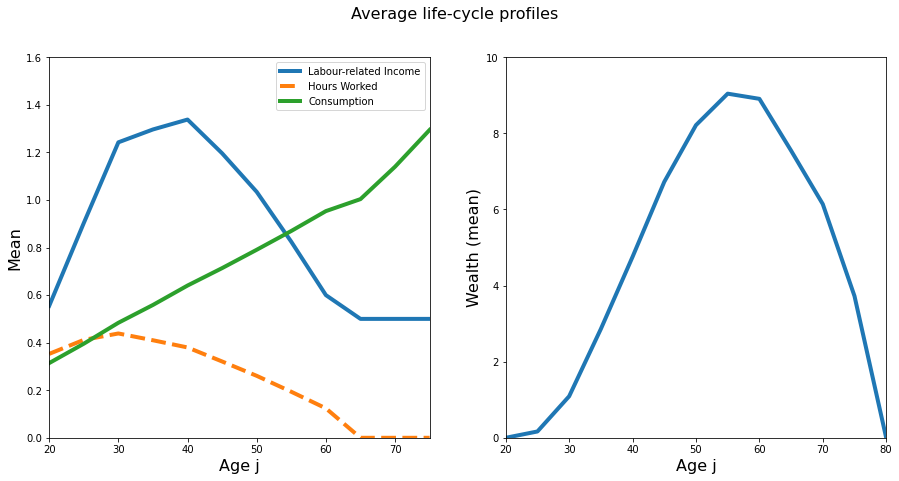

In [83]:
fig, ax = plt.subplots(1,2, figsize = (15,7))
fig.suptitle('Average life-cycle profiles',fontsize = '16')
plt.rcParams['lines.linewidth'] = '4'

for i in range(2):
    ax[i].set_xlabel('Age j',fontsize = '16')
        


ax[0].plot(age, (w[0]*y_coh[:,0]+pen[:,0])/INC[0], label = 'Labour-related Income' )
ax[0].plot(age, l_coh[:,0], label = 'Hours Worked',linestyle = '--')
ax[0].plot(age, c_coh[:,0]/INC[0], label = 'Consumption')
ax[0].legend()
ax[0].set_ylabel('Mean',fontsize = '16')
ax[0].set_ylim(0,1.6)
ax[0].set_xlim(20,75)

ax[1].plot(np.append(age,80), np.append(a_coh[:,0],0)*5/INC[0])
ax[1].set_ylabel('Wealth (mean)',fontsize = '16')
ax[1].set_ylim(0,10)
ax[1].set_xlim(20,80)


In [108]:
var_c = np.zeros(J)
exp_c = np.zeros(J)
mas_c = np.zeros(J)
var_y = np.zeros(J)
exp_y = np.zeros(J)
mas_y = np.zeros(J)

for j in range(J):
    for i in range(NA+1):
        for p in range(NP):
            for s in range(NS):
                
                if c[j,i,p,s,0] > 0:
                    temp = np.log(c[j,i,p,s,0])
                    exp_c[j] += temp*Φ[j,i,p,s,0]
                    var_c[j] += temp**2*Φ[j,i,p,s,0]
                    mas_c[j] += Φ[j,i,p,s,0]
                    
                    
                if l[j,i,p,s,0] > 0.01:
                    temp = np.log(w[0]*eff[j]*θ[p]*η[s]*l[j,i,p,s,0])
                    exp_y[j] += temp*Φ[j,i,p,s,0]
                    var_y[j] += temp**2*Φ[j,i,p,s,0]
                    mas_y[j] += Φ[j,i,p,s,0]
                
                
                
exp_c = exp_c/np.maximum(mas_c,1e-4)
var_c = var_c/np.maximum(mas_c,1e-4)
var_c += -exp_c**2

exp_y = exp_y/np.maximum(mas_y,1e-4)
var_y = var_y/np.maximum(mas_y,1e-4)
var_y += -exp_y**2

(20.0, 60.0)

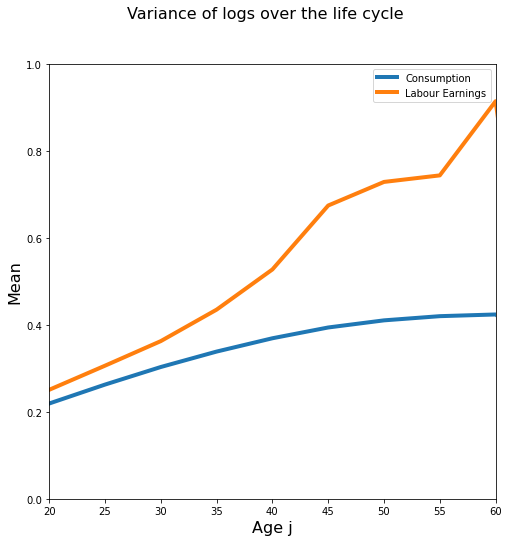

In [112]:
fig, ax = plt.subplots(1, figsize = (8,8))
fig.suptitle('Variance of logs over the life cycle',fontsize = '16')
plt.rcParams['lines.linewidth'] = '4'

ax.set_xlabel('Age j',fontsize = '16')
        


ax.plot(age,var_c, label = 'Consumption' )
ax.plot(age,var_y, label = 'Labour Earnings' )
ax.legend()
ax.set_ylabel('Mean',fontsize = '16')
ax.set_ylim(0,1)
ax.set_xlim(20,60)

